# Imports

In [1]:
from pandas import read_csv
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.feature_selection import RFECV
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import adjusted_rand_score
from sklearn.pipeline import make_pipeline
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import GenericUnivariateSelect, chi2
from sklearn.model_selection import cross_validate

# KIRC
--------------------------------------------------------------------------------------------------------------------------
# Importing data

In [2]:
gene = read_csv("M://scriptie/data_MDICC2/KIRC/data/gene1.csv")
methyl = read_csv("M://scriptie/data_MDICC2/KIRC/data/methyl.csv")
miRNA = read_csv("M://scriptie/data_MDICC2/KIRC/data/miRNA1.csv")
label = read_csv("M://scriptie/data_MDICC2/KIRC/label.csv")
#survival = read_csv("survival.csv")

# Data exploration

In [ ]:
print("The shape of gene is {}".format(gene.shape))
gene.describe()
#gene.iloc[:,1].describe() #use this for a single column

In [ ]:
print("The shape of methyl is {}".format(methyl.shape))
methyl.describe()

In [ ]:
print("The shape of miRNA is {}".format(miRNA.shape))
miRNA.describe()

In [ ]:
print("The shape of survival is {}".format(survival.shape))
survival.head()

In [ ]:
print("The shape of label is {}".format(label.shape))
label.head()

# miRNA

In [ ]:
total_count = 0
for column_name in miRNA.columns:
  column = miRNA[column_name]
  total_count += (column == 0).sum()

print('Amount of zeroes in miRNA is {} out of {}'.format(total_count, miRNA.shape[0]*miRNA.shape[1]))

In [3]:
def load_data_miRNA():
    X = miRNA.T
    header = list(X.iloc[0,:])
    X = X.drop(X.index[[0]])
    X.columns = header
    y = label.iloc[:,1]
    return X, y

### Random Forest

In [ ]:
X, y = load_data_miRNA()
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, random_state=0)

rfc = RandomForestClassifier(n_estimators = 100,random_state=0,criterion='gini') 
selector = SelectFromModel(estimator=rfc, 
                      threshold=0.01)

scoring = ['accuracy','roc_auc']
cv_results = cross_validate(rfc, X, y, cv=10, scoring=scoring)
print(cv_results.keys())
print(cv_results['test_accuracy'])

# Train the selector
selector = selector.fit(X_train, y_train)
print(selector.get_support())
selected_feat = X_train.columns[(selector.get_support())]
print(len(selected_feat))
feat = X[selected_feat].T
#feat.to_csv("KIRC_miRNA_rf_tt.csv")

### Variance Threshold

In [ ]:
load_data_miRNA()
selector = VarianceThreshold()
selector = selector.fit(X)

### RFECV

In [ ]:
X, y = load_data_miRNA()
clf = RandomForestClassifier(n_estimators=10, random_state=10)
cv = StratifiedKFold(5)
selector = RFECV(
    estimator=clf,
    step=1,
    cv=cv,
    scoring="accuracy",
    n_jobs=-1)
selector = selector.fit(X,y)
print(np.unique(selector.ranking_, return_counts=True))
print(selector.score(X,y))

### K-best feature selection

In [7]:
X, y = load_data_miRNA()
#X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, stratify=y, random_state=10)
for i in range(3,11):
    selector = GenericUnivariateSelect(chi2, mode='k_best', param=X.shape[1]//i)

    selector = selector.fit(X, y)
    selected_feat = X.columns[(selector.get_support())]
    print(len(selected_feat),miRNA.shape[0])
    feat = X[selected_feat].T
    file = "KIRC_miRNA_kbest_{}.csv".format(i)
    feat.to_csv(file)

626 1879
469 1879
375 1879
313 1879
268 1879
234 1879
208 1879
187 1879


### Transform to csv

In [ ]:
new_X = selector.transform(X)
print(new_X.shape)
new_X = pd.DataFrame(new_X, columns=selector.get_feature_names_out(), index=miRNA.columns[1:]) 
new_X.to_csv('newmiRNA_variance.csv')

# methyl

In [ ]:
total_count = 0
for column_name in methyl.columns:
  column = methyl[column_name]
  total_count += (column == 0).sum()

print('Amount of zeroes in methyl is {} out of {}'.format(total_count, methyl.shape[0]*methyl.shape[1]))

In [8]:
def load_data_methyl():
    X = methyl.T
    header = list(X.iloc[0,:])
    X = X.drop(X.index[[0]])
    X.columns = header
    y = label.iloc[:,1]
    return X, y

### Variance Threshold

In [ ]:
X, y = load_data_methyl()
selector = VarianceThreshold()
selector = selector.fit(X)

### RFECV

In [ ]:
X, y = load_data_methyl()
clf = RandomForestClassifier(n_estimators=10, random_state=10)
cv = StratifiedKFold(5)
selector = RFECV(
    estimator=clf,
    step=1,
    cv=cv,
    scoring="accuracy",
    n_jobs=-1)
selector = selector.fit(X,y)

print(np.unique(selector.ranking_, return_counts=True))
print("Score: {}".format(selector.score(X,y)))

### K-best feature selection

In [9]:
X, y = load_data_methyl()
print(X.shape)
#X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, stratify=y, random_state=10)
for i in range(3,11):
    selector = GenericUnivariateSelect(chi2, mode='k_best', param=X.shape[1]//i)
    selector = selector.fit(X, y)
    selected_feat = X.columns[(selector.get_support())]
    print(len(selected_feat),methyl.shape[0])
    feat = X[selected_feat].T
    file = "KIRC_methyl_kbest_{}.csv".format(i)
    feat.to_csv(file)

(289, 22928)
7642 22928
5732 22928
4585 22928
3821 22928
3275 22928
2866 22928
2547 22928
2292 22928


### Random Forest

In [ ]:
load_data_methyl()
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, random_state=0)

rfc = RandomForestClassifier(n_estimators = 100,random_state=0,criterion='gini') 
selector = SelectFromModel(estimator=rfc, 
                      threshold=0.01)
# Train the selector
selector = selector.fit(X_train, y_train)
print(selector.get_support())
selected_feat = X_train.columns[(selector.get_support())]
print(len(selected_feat))
feat = X[selected_feat].T
feat.to_csv("KIRC_methyl_rf_tt.csv")

### Transform to csv

In [ ]:
new_X = selector.transform(X)
print(new_X.shape)
new_X = pd.DataFrame(new_X, columns=selector.get_feature_names_out(), index=miRNA.columns[1:]) 
new_X.to_csv('newmethyl_variance.csv')

# gene

In [ ]:
total_count = 0
for column_name in gene.columns:
  column = gene[column_name]
  total_count += (column == 0).sum()

print('Amount of zeroes in gene is {} out of {}'.format(total_count, gene.shape[0]*gene.shape[1]))

In [10]:
def load_data_gene():
    X = gene.T
    header = list(X.iloc[0,:])
    X = X.drop(X.index[[0]])
    X.columns = header
    y = label.iloc[:,1]
    return X, y

### Variance Threshold

In [ ]:
X, y = load_data_gene()
selector = VarianceThreshold()
selector = selector.fit(X)

### RFECV

In [ ]:
X, y = load_data_gene()
clf = RandomForestClassifier(n_estimators=10, random_state=10)
cv = StratifiedKFold(5)
selector_g = RFECV(
    estimator=clf,
    step=1,
    cv=cv,
    scoring="accuracy",
    n_jobs=-1)
selector_g = selector_g.fit(X,y)

print(selector_g.score(X,y))
print(np.unique(selector_g.ranking_, return_counts=True))

### K-best feature selection

In [12]:
X, y = load_data_gene()
print(X.shape)
#X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, stratify=y, random_state=10)
for i in range(3,11):
    selector = GenericUnivariateSelect(chi2, mode='k_best', param=X.shape[1]//i)
    selector = selector.fit(X, y)
    selected_feat = X.columns[(selector.get_support())]
    print(len(selected_feat),gene.shape[0])
    feat = X[selected_feat].T
    file = "KIRC_gene_kbest_{}.csv".format(i)
    feat.to_csv(file)

(289, 58316)
19438 58316
14579 58316
11663 58316
9719 58316
8330 58316
7289 58316
6479 58316
5831 58316


### Random Forest

In [ ]:
X, y = load_data_gene()
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, random_state=0)

rfc = RandomForestClassifier(n_estimators = 100,random_state=0,criterion='gini') 
selector = SelectFromModel(estimator=rfc, 
                      threshold=0.01)
# Train the selector
selector = selector.fit(X_train, y_train)
print(selector.get_support())
selected_feat = X_train.columns[(selector.get_support())]
print(len(selected_feat))
#print(adjusted_rand_score(selector.predict(X_test)), y_test)
#feat = X[selected_feat].T
#feat.to_csv("KIRC_gene_rf_tt.csv")

### Transform to csv

In [ ]:
new_X = selector.transform(X)
print(new_X.shape)
new_X = pd.DataFrame(new_X.T, columns=gene.columns[1:], index=selector.get_feature_names_out()) 
new_X.to_csv('newgene_variance.csv')

# ################################################################


# LUAD
--------------------------------------------------------------------------------------------------------------------------
# Importing data

In [2]:
gene = read_csv("M://scriptie/data_MDICC2/LUAD/data/gene.csv")
methyl = read_csv("M://scriptie/data_MDICC2/LUAD/data/methyl.csv")
miRNA = read_csv("M://scriptie/data_MDICC2/LUAD/data/miRNA.csv")
label = read_csv("M://scriptie/data_MDICC2/LUAD/label.csv")
#survival = read_csv("survival.csv")

# Data exploration

In [ ]:
print("The shape of gene is {}".format(gene.shape))
gene.describe()
#gene.iloc[:,1].describe() #use this for a single column

In [ ]:
print("The shape of methyl is {}".format(methyl.shape))
methyl.describe()

In [ ]:
print("The shape of miRNA is {}".format(miRNA.shape))
miRNA.describe()

In [ ]:
print("The shape of survival is {}".format(survival.shape))
survival.head()

In [ ]:
print("The shape of label is {}".format(label.shape))
label.head()

# miRNA

In [3]:
total_count = 0
for column_name in miRNA.columns:
  column = miRNA[column_name]
  total_count += (column == 0).sum()

print('Amount of zeroes in miRNA is {} out of {}'.format(total_count, miRNA.shape[0]*miRNA.shape[1]))

Amount of zeroes in miRNA is 561698 out of 876546


In [4]:
def load_data_miRNA():
    X = miRNA.T
    header = list(X.iloc[0,:])
    X = X.drop(X.index[[0]])
    X.columns = header
    y = label.iloc[:,1]
    return X, y

### Random Forest

In [ ]:
X, y = load_data_miRNA()
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, random_state=0)

rfc = RandomForestClassifier(n_estimators = 100,random_state=0,criterion='gini') 
selector = SelectFromModel(estimator=rfc, 
                      threshold=0.01)
# Train the selector
selector = selector.fit(X_train, y_train)
print(selector.get_support())
selected_feat = X_train.columns[(selector.get_support())]
print(len(selected_feat))
feat = X[selected_feat].T
feat.to_csv("LUAD_miRNA_rf_tt.csv")

### Variance Threshold

In [ ]:
X, y = load_data_miRNA()
selector = VarianceThreshold()
selector = selector.fit(X)

### RFECV

In [ ]:
clf = RandomForestClassifier(n_estimators=10, random_state=10)
cv = StratifiedKFold(5)
selector = RFECV(
    estimator=clf,
    step=1,
    cv=cv,
    scoring="accuracy",
    n_jobs=-1)
selector = selector.fit(X,y)
print(np.unique(selector.ranking_, return_counts=True))
print(selector.score(X,y))

### K-best feature selection

In [6]:
X, y = load_data_miRNA()
#X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, random_state=10)
for i in range(11,16):
    selector = GenericUnivariateSelect(chi2, mode='k_best', param=X.shape[1]//i)
    selector = selector.fit(X, y)
    selected_feat = X.columns[(selector.get_support())]
    print(len(selected_feat),miRNA.shape[0])
    feat = X[selected_feat].T
    file = "LUAD_miRNA_kbest_{}.csv".format(i)
    feat.to_csv(file)

171 1881
156 1881
144 1881
134 1881
125 1881


1881
1881


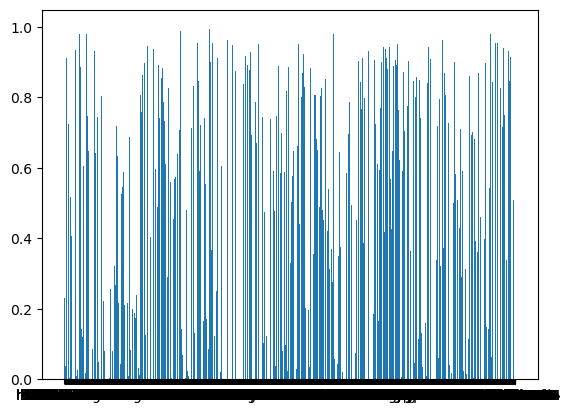

In [35]:
X, y = load_data_miRNA()
selector = GenericUnivariateSelect(chi2, mode='k_best', param=X.shape[1]//3)
selector = selector.fit(X, y)
print(len(X.columns[:]))
print(len(selector.pvalues_))
plt.figure()
plt.bar(X.columns[:], selector.pvalues_)
plt.show()

Index(['hsa-let-7a-1', 'hsa-let-7a-2', 'hsa-let-7a-3', 'hsa-let-7b',
       'hsa-let-7c', 'hsa-let-7d', 'hsa-mir-1-1', 'hsa-mir-1-2',
       'hsa-mir-105-1', 'hsa-mir-105-2',
       ...
       'hsa-mir-892a', 'hsa-mir-9-1', 'hsa-mir-9-2', 'hsa-mir-9-3',
       'hsa-mir-93', 'hsa-mir-935', 'hsa-mir-937', 'hsa-mir-944', 'hsa-mir-96',
       'hsa-mir-98'],
      dtype='object', length=627)
1881
627


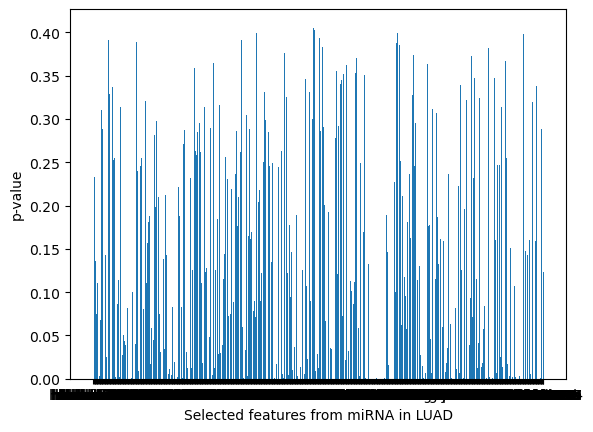

In [63]:
selected_feat = X.columns[(selector.get_support())]
print(selected_feat)
cols_index = [X.columns.get_loc(col) for col in selected_feat]
print(len(selector.pvalues_))
print(len(selector.pvalues_[cols_index]))
plt.plot()
plt.bar(selected_feat,selector.pvalues_[cols_index])
plt.xlabel("Selected features from miRNA in LUAD")
plt.ylabel("p-value")
plt.show()
#significant = list(filter(lambda num: num <= 0.5, selector.pvalues_))
#print(len(significant))

### Transform to csv

In [ ]:
new_X = selector.transform(X)
print(new_X.shape)
new_X = pd.DataFrame(new_X.T, columns=miRNA.columns[1:], index=selector.get_feature_names_out()) 
new_X.to_csv('M://scriptie/data_MDICC2/LUAD/rf/miRNA_rf.csv')

# methyl

In [ ]:
total_count = 0
for column_name in methyl.columns:
  column = methyl[column_name]
  total_count += (column == 0).sum()

print('Amount of zeroes in methyl is {} out of {}'.format(total_count, methyl.shape[0]*methyl.shape[1]))

In [7]:
def load_data_methyl():
    X = methyl.T
    header = list(X.iloc[0,:])
    X = X.drop(X.index[[0]])
    X.columns = header
    y = label.iloc[:,1]
    return X, y

### Random Forest

In [ ]:
X, y = load_data_methyl()
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, random_state=0)

rfc = RandomForestClassifier(n_estimators = 100,random_state=0,criterion='gini') 
selector = SelectFromModel(estimator=rfc, 
                      threshold=0.01)
# Train the selector
selector = selector.fit(X_train, y_train)
print(selector.get_support())
selected_feat = X_train.columns[(selector.get_support())]
print(len(selected_feat))
feat = X[selected_feat].T
feat.to_csv("LUAD_methyl_rf_tt.csv")

### Variance Threshold

In [ ]:
X, y = load_data_methyl()
selector = VarianceThreshold()
selector = selector.fit(X)

### RFECV

In [ ]:
X, y = load_data_methyl()
clf = RandomForestClassifier(n_estimators=10, random_state=10)
cv = StratifiedKFold(5)
selector = RFECV(
    estimator=clf,
    step=1,
    cv=cv,
    scoring="accuracy",
    n_jobs=-1)
selector = selector.fit(X,y)

print(np.unique(selector.ranking_, return_counts=True))
print("Score: {}".format(selector.score(X,y)))

### K-best feature selection

In [8]:
X, y = load_data_methyl()
#X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, random_state=10)
for i in range(11,16):
    selector = GenericUnivariateSelect(chi2, mode='k_best', param=X.shape[1]//i)
    selector = selector.fit(X, y)
    selected_feat = X.columns[(selector.get_support())]
    print(len(selected_feat),methyl.shape[0])
    feat = X[selected_feat].T
    file = "LUAD_methyl_kbest_{}.csv".format(i)
    feat.to_csv(file)

2011 22123
1843 22123
1701 22123
1580 22123
1474 22123


### Transform to csv

In [ ]:
new_X = selector.transform(X)
print(new_X.shape)
new_X = pd.DataFrame(new_X.T, columns=miRNA.columns[1:], index=selector.get_feature_names_out()) 
new_X.to_csv('M://scriptie/data_MDICC2/LUAD/rf/methyl_rf.csv')

# gene

In [ ]:
total_count = 0
for column_name in gene.columns:
  column = gene[column_name]
  total_count += (column == 0).sum()

print('Amount of zeroes in gene is {} out of {}'.format(total_count, gene.shape[0]*gene.shape[1]))

In [9]:
def load_data_gene():
    X = gene.T
    header = list(X.iloc[0,:])
    X = X.drop(X.index[[0]])
    X.columns = header
    y = label.iloc[:,1]
    return X, y

### Random forest

In [ ]:
X, y = load_data_gene()
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, random_state=0)

rfc = RandomForestClassifier(n_estimators = 100,random_state=0,criterion='gini') 
selector = SelectFromModel(estimator=rfc, 
                      threshold=0.01)
# Train the selector
selector = selector.fit(X_train, y_train)
print(selector.get_support())
selected_feat = X_train.columns[(selector.get_support())]
print(len(selected_feat))
feat = X[selected_feat].T
feat.to_csv("LUAD_gene_rf_tt.csv")

### Variance Threshold

In [ ]:
selector = VarianceThreshold()
selector = selector.fit(X)

### RFECV

In [ ]:
clf = RandomForestClassifier(n_estimators=10, random_state=10)
cv = StratifiedKFold(5)
selector_g = RFECV(
    estimator=clf,
    step=1,
    cv=cv,
    scoring="accuracy",
    n_jobs=-1)
selector_g = selector_g.fit(X,y)

print(selector_g.score(X,y))
print(np.unique(selector_g.ranking_, return_counts=True))

### K-best feature selection

In [10]:
X, y = load_data_gene()
#X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, random_state=10)
for i in range(11,16):
    selector = GenericUnivariateSelect(chi2, mode='k_best', param=X.shape[1]//i)
    selector = selector.fit(X, y)
    selected_feat = X.columns[(selector.get_support())]
    print(len(selected_feat),gene.shape[0])
    feat = X[selected_feat].T
    file = "LUAD_gene_kbest_{}.csv".format(i)
    feat.to_csv(file)

5498 60483
5040 60483
4652 60483
4320 60483
4032 60483


### Transform to csv

In [ ]:
new_X = selector.transform(X)
print(new_X.shape)
new_X = pd.DataFrame(new_X.T, columns=gene.columns[1:], index=selector.get_feature_names_out()) 
new_X.to_csv('M://scriptie/data_MDICC2/LUAD/rf/gene_rf.csv')